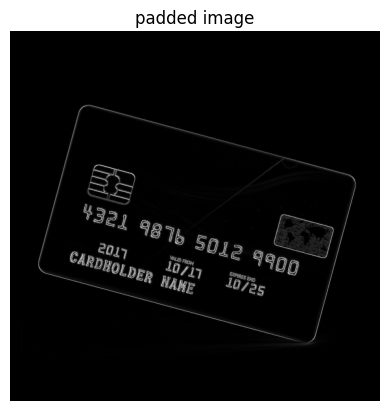

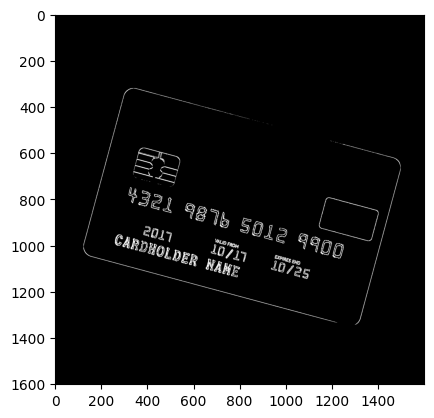

(4, 2)


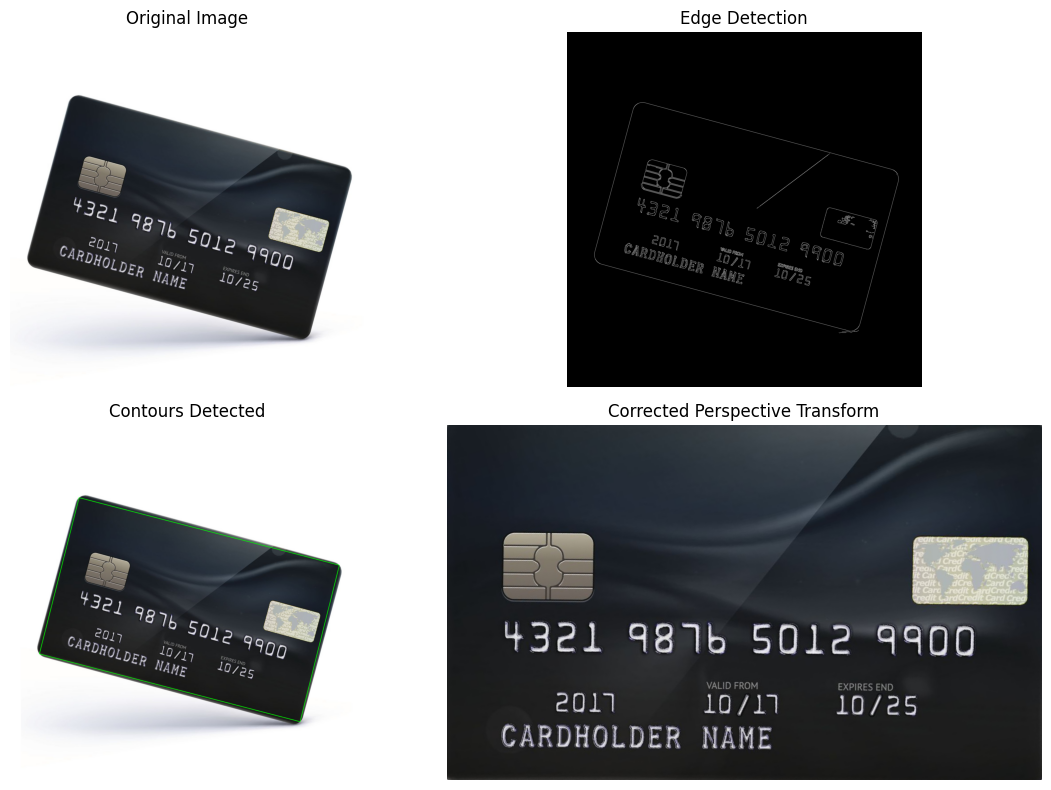

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Load the image
image = cv2.imread('06 - Hatetlewe7 hatlewe7.jpg')

pad_size = 50

# Pad the image with white color (255)
padded_image = cv2.copyMakeBorder(image, pad_size, pad_size, pad_size, pad_size, 
                                  cv2.BORDER_CONSTANT, value=[255, 255, 255])
plt.imshow(padded_image)
plt.title('padded image')
plt.axis('off')

gray = cv2.cvtColor(padded_image, cv2.COLOR_BGR2GRAY)
kernel_size = (3,3)  # Width and height of the rectangle
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

# Perform dilation
dilated_image = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, kernel)
plt.imshow(dilated_image, cmap="gray")
plt.show()

thresh = cv2.threshold(dilated_image, 100, 140, cv2.THRESH_BINARY)[1]
plt.imshow(thresh, cmap="gray")
plt.show()
# Preprocess the image
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# Detect contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def find_card_contour(contours):
    # Iterate over contours and find the one with 4 points and is rectangular
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4 and cv2.contourArea(approx) > 1000:  # Check if it's a quadrilateral and area is significant
            return approx
    return None

# Find card contour
approx = find_card_contour(contours)

if approx is None:
    print("No valid card contour found. Using edge bounding box.")
    # Find bounding box of edges
    x, y, w, h = cv2.boundingRect(edges)
    approx = np.array([
        [x, y],
        [x + w, y],
        [x + w, y + h],
        [x, y + h]
    ], dtype="float32")

# Ensure there are exactly 4 points
if len(approx) != 4:
    print("Detected contour does not have exactly 4 points. Using fallback.")
    # Fallback to using detected edges bounding box if no valid contour
    x, y, w, h = cv2.boundingRect(edges)
    approx = np.array([
        [x, y],
        [x + w, y],
        [x + w, y + h],
        [x, y + h]
    ], dtype="float32")

# Sort the points to ensure correct order (top-left, top-right, bottom-right, bottom-left)
def order_points(pts):
    pts = np.array(pts, dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    ordered_pts = np.zeros((4, 2), dtype="float32")
    ordered_pts[0] = pts[np.argmin(s)]
    ordered_pts[2] = pts[np.argmax(s)]
    ordered_pts[1] = pts[np.argmin(diff)]
    ordered_pts[3] = pts[np.argmax(diff)]
    return ordered_pts

# Ordered points
ordered_approx = order_points(approx.reshape(4, 2))

# Perspective Transform
def four_point_transform(image, pts):
    rect = np.array(pts, dtype="float32")
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

# Perform perspective transform
warped_image = four_point_transform(padded_image, ordered_approx)

# Check orientation and rotate if necessary
def correct_orientation(image):
    (h, w) = image.shape[:2]
    if w < h:
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, 90, 1.0)
        rotated = cv2.warpAffine(image, M, (h, w), flags=cv2.INTER_CUBIC)
        return rotated
    return image

# Correct orientation if needed
corrected_image = correct_orientation(warped_image)

# Display results
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Edge Detection')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Contours Detected')
# Draw contours on a copy of the original image
contour_image = padded_image.copy()
if approx is not None:
    approx = np.int32(approx).reshape(-1, 2)  # Ensure the points are integers
    print(approx.shape[:2])
    cv2.drawContours(contour_image, [approx], -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Corrected Perspective Transform')
plt.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


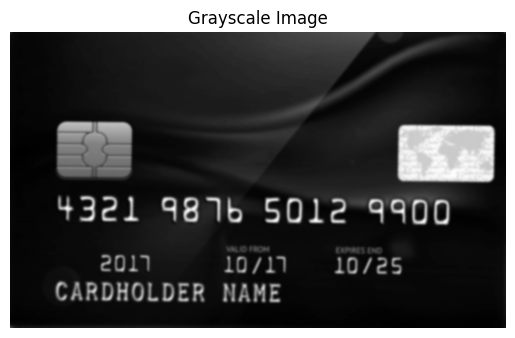

In [53]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils import contours
import argparse


def showImage(name, image, cmap=None):
    plt.imshow(image, cmap=cmap)
    plt.axis('off')  # Hide axis
    plt.title(name)
    plt.show()

# Load the image
image = corrected_image

blurred_image = cv2.GaussianBlur(image, (15, 15), 0)

# Convert to grayscale
image_gray = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)

# Display the grayscale image
showImage("Grayscale Image", image_gray, cmap='gray')

# median = cv2.medianBlur(image, 51)
# showImage("median Image", median, cmap='gray')



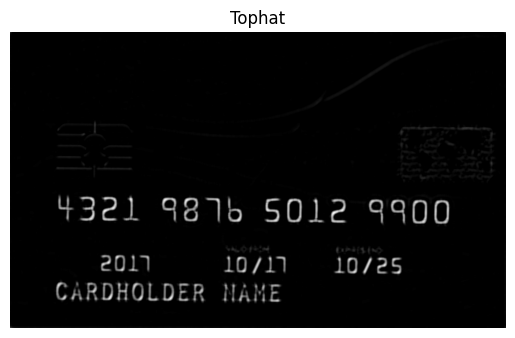

In [54]:
# Apply a tophat (whitehat) morphological operator
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
tophat = cv2.morphologyEx(image_gray, cv2.MORPH_TOPHAT, rectKernel)

# Display the tophat image
showImage("Tophat", tophat, cmap='gray')



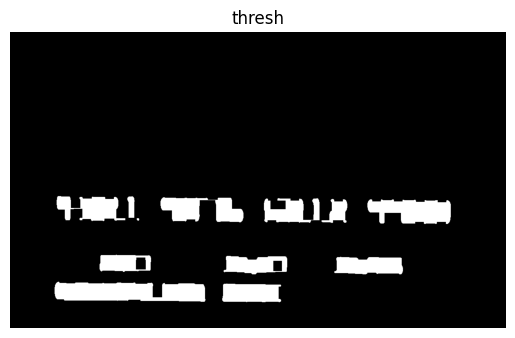

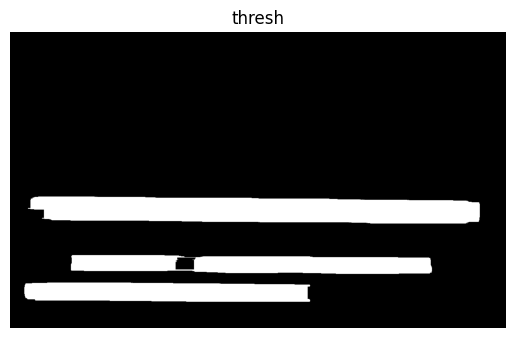

In [55]:
# compute the Scharr gradient of the tophat image, then scale
# the rest back into the range [0, 255]
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0,ksize=31)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
# Adjust scaling factor to stretch the gradient
scaling_factor = 300.0  # Increase this value to stretch the gradient more
gradX = (scaling_factor * (gradX - minVal) / (maxVal - minVal))
gradX = np.clip(gradX, 0, 255)  # Ensure values are within [0, 255]
gradX = gradX.astype("uint8")

# apply a closing operation using the rectangular kernel to help
# cloes gaps in between credit card number digits, then apply
# Otsu's thresholding method to binarize the image
rectKernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel2)
thresh = cv2.threshold(gradX, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# apply a second closing operation to the binary image, again
# to help close gaps between credit card number regions
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
showImage("thresh", thresh, cmap='gray')
blurred_image = cv2.GaussianBlur(thresh, (401, 1), 0)
_, thresholded_image = cv2.threshold(blurred_image, 30, 255, cv2.THRESH_BINARY)

showImage("thresh", thresholded_image, cmap='gray')



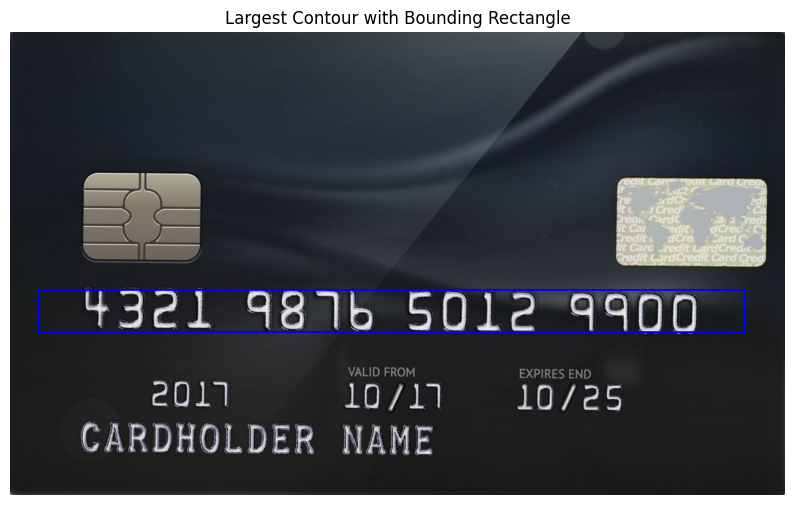

In [56]:
# Find contours
contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize variables for largest contour
max_width = 0
largest_contour = None
bounding_rect = None

# Iterate over contours to find the one with the maximum width
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > max_width:
        max_width = w
        largest_contour = contour
        bounding_rect = (x, y, w, h)

# Draw the largest contour
if largest_contour is not None:
    # cv2.drawContours(image, [largest_contour], -1, (0, 0, 0), 2)

    # Draw the bounding rectangle
    x, y, w, h = bounding_rect
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Convert image to RGB for displaying with matplotlib
image_contours = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(image_contours)
plt.title('Largest Contour with Bounding Rectangle')
plt.axis('off')
plt.show()